<a href="https://colab.research.google.com/github/ValentynaGrach/ml-homeworks/blob/main/%D0%94%D0%97__15_RNN_ValentynaGrach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Завантаження IMDB датасету

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout, GRU
import matplotlib.pyplot as plt

In [ ]:
# Завантажуємо датасет
num_words = 10000  # Використовуємо топ-10 000 слів
maxlen = None  # Не обрізаємо відгуки
seed = 113
start_char = 1
oov_char = 2
index_from = 3

# Завантажуємо датасет IMDB
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words=num_words, maxlen=maxlen, seed=seed,
    start_char=start_char, oov_char=oov_char, index_from=index_from)

# Виводимо інформацію про дані
print("Розмір тренувального набору:", x_train.shape, y_train.shape)
print("Розмір тестового набору:", x_test.shape, y_test.shape)
print("Приклад відгуку:", x_train[0])  # Виглядає як список чисел
print("Мітка класу:", y_train[0])  # 0 - негативний, 1 - позитивний

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Розмір тренувального набору: (25000,) (25000,)
Розмір тестового набору: (25000,) (25000,)
Приклад відгуку: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104,

- У нас **25 000 тренувальних** і **25 000 тестових** прикладів.
- Кожен відгук — це список чисел, які представляють слова.
- Клас мітки **1** означає позитивний відгук (0 — негативний).

⏭ **Наступний крок**: декодування тексту, щоб краще розуміти дані, переведемо ці числа назад у слова.

---

## декодування тексту

In [ ]:
# Завантажуємо словник індексів слів
word_index = keras.datasets.imdb.get_word_index()

# Додаємо зсув `index_from=3`, щоб збігалося з `load_data`
word_index = {k: (v + 3) for k, v in word_index.items()}

# Додаємо спеціальні токени
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # Позначаємо невідомі слова
word_index["<UNUSED>"] = 3

# Реверсивний словник (індекси → слова)
reverse_word_index = {v: k for k, v in word_index.items()}

# Декодуємо перший відгук
decoded_review = " ".join([reverse_word_index.get(i, "<UNK>") for i in x_train[0]])

print("\nДекодований відгук:\n", decoded_review)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step

Декодований відгук:
 <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the 

✅ Бачимо, як виглядає реальний відгук після декодування.  
- Відгук починається з **`<START>`** – це спеціальний токен, що позначає початок тексту.  
- **Слова `<UNK>`** – це невідомі слова, яких немає у 10 000 найпопулярніших у словнику. Вони заміщені `<UNK>` (unknown).   

---

⏭  Наступний крок: Попередня обробка тексту.

---



# Попередня обробка тексту

Тепер запускаємо код з **паддінгом (доповненням до однакової довжини)**.

In [ ]:
# Максимальна довжина відгуку
max_length = 250

# Доповнюємо або обрізаємо всі відгуки до однієї довжини
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

# Перевіримо форму
print("Форма x_train після обробки:", x_train.shape)
print("Форма x_test після обробки:", x_test.shape)

Форма x_train після обробки: (25000, 250)
Форма x_test після обробки: (25000, 250)


✅ Тепер всі відгуки мають однакову довжину (250 слів), і ми готові будувати RNN! 🚀

# Створення простої RNN

📌 створимо рекурентну нейромережу (SimpleRNN) для класифікації відгуків.  

- **Embeddings**: Перетворимо індекси слів у вектори для роботи з ними.  
- **SimpleRNN**: Додаємо рекурентний шар.  
- **Dense**: Фінальний шар для передбачення класу (0 або 1).

In [ ]:
# Гіперпараметри
embedding_dim = 32  # Розмірність векторів слів

# Створюємо модель
model_rnn = Sequential([
    Embedding(input_dim=10000, output_dim=embedding_dim),  # Векторизація слів
    SimpleRNN(32),  # Рекурентний шар (SimpleRNN)
    Dense(1, activation='sigmoid')])  # Фінальний шар для класифікації (ймовірність)

# Виконуємо "будівництво" моделі перед виводом структури
model_rnn.build(input_shape=(None, 250))

# Компільовуємо модель
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Виводимо архітектуру
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 322,113 (1.23 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

✅ Модель правильно побудувалася. Тепер вона готова до навчання!

# Навчання моделі та оцінка якості

## навчання моделі SimpleRNN на тренувальних даних.

In [ ]:
# Додаємо ім'я моделі
model_rnn.name = "IMDB-SimpleRNN"

# Навчання моделі
epochs = 5
batch_size = 64

history_simple_rnn = model_rnn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5099 - loss: 0.6946 - val_accuracy: 0.5130 - val_loss: 0.6952
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5304 - loss: 0.6905 - val_accuracy: 0.5078 - val_loss: 0.6937
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5900 - loss: 0.6589 - val_accuracy: 0.5055 - val_loss: 0.7091
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6523 - loss: 0.5588 - val_accuracy: 0.5078 - val_loss: 0.7649
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6758 - loss: 0.4851 - val_accuracy: 0.5160 - val_loss: 0.8219


🔍 **Аналіз навчання**  

📉 **Loss**: на тренуванні зменшується, на валідації **зростає** → **перенавчання**.  
📈 **Accuracy**: на тренуванні **зростає**, на валідації **стагнує** → слабка генералізація.  

---

✅ **Висновок**: модель **запам’ятовує, але не узагальнює**.  
⏭  **Наступний крок** → замінюємо SimpleRNN на LSTM/GRU. 🚀  

# Оптимізація (LSTM/GRU, покращення гіперпараметрів)

📌 Покращення моделі: LSTM замість SimpleRNN
LSTM (Long Short-Term Memory) краще працює з послідовними даними, ніж SimpleRNN. Він запам’ятовує довготривалі залежності, що важливо для аналізу тексту.

## модель з LSTM

In [ ]:
# Створюємо модель з LSTM
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32),
    LSTM(64),  # Заміна SimpleRNN на LSTM
    Dense(1, activation='sigmoid')])

model_lstm.build(input_shape=(None, 250))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 344,897 (1.32 MB)

 Trainable params: 344,897 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

🚀 **Модель оновлена!**   

Спробуємо замість SimpleRNN використати **LSTM**, що значно покращує обробку тексту.  

---

🔧 Навчаємо модель IMDB-LSTM

In [ ]:
# Додаємо ім'я моделі
model_lstm.name = "IMDB-LSTM"

# Навчання моделі
epochs = 5
batch_size = 64

history_lstm = model_lstm.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5105 - loss: 0.6934 - val_accuracy: 0.5289 - val_loss: 0.6918
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5859 - loss: 0.6742 - val_accuracy: 0.5194 - val_loss: 0.6913
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5842 - loss: 0.6537 - val_accuracy: 0.5144 - val_loss: 0.6889
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6004 - loss: 0.6551 - val_accuracy: 0.7391 - val_loss: 0.5849
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7342 - loss: 0.5507 - val_accuracy: 0.7456 - val_loss: 0.5502


🔍 **Аналіз навчання IMDB-LSTM**  

📉 **Loss**: на тренуванні **зменшується**, на валідації також **поступово знижується** → модель навчається правильно.  
📈 **Accuracy**: на тренуванні **зростає**, на валідації **значно покращилася (до 74.56%)** → LSTM краще узагальнює дані, ніж SimpleRNN.  

✅ **Висновок**: модель **вчиться розпізнавати патерни**, але можливо ще не досягла оптимальних результатів.  
⏭ **Наступний крок** → збільшуємо кількість епох, додаємо `Dropout()` для стабільності. 🚀

---

In [ ]:
# Покращена LSTM модель
model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=32),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid')])

# Додаємо ім'я моделі
model_lstm.name = "IMDB-Improved-LSTM"

# Компільовуємо модель
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Навчання покращеної LSTM
epochs = 15
batch_size = 64

history_lstm = model_lstm.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.5115 - loss: 0.6921 - val_accuracy: 0.5627 - val_loss: 0.6791
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5292 - loss: 0.6843 - val_accuracy: 0.5262 - val_loss: 0.6834
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.5079 - loss: 0.6876 - val_accuracy: 0.5186 - val_loss: 0.6913
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5370 - loss: 0.6880 - val_accuracy: 0.5000 - val_loss: 0.7051
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5099 - loss: 0.6961 - val_accuracy: 0.5137 - val_loss: 0.6912
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5598 - loss: 0.6771 - val_accuracy: 0.5352 - val_loss: 0.6763
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7038 - loss: 0.5759 - val_accuracy: 0.8093 - val_loss: 0.4405
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8624 - loss: 0.3593 - 

🔍 **Аналіз покращеної LSTM-моделі**  

📉 **Loss**: на тренуванні **значно зменшується**, на валідації після 10-ї епохи **починає зростати** → можливе перенавчання.  
📈 **Accuracy**: на тренуванні **зросла до 97%**, на тесті **стабілізувалася на 85%** → хороша узагальнююча здатність, але є ризик перенавчання.  

✅ **Висновок**: модель ефективно вивчає патерни, але після 10-ї епохи можливе переобучення.  
⏭ **Наступний крок** → тестуємо GRU та аналізуємо стабільність результатів. 🚀

---

## модель з GRU

In [ ]:
# Створюємо модель на основі GRU
model_gru = Sequential([
    Embedding(input_dim=10000, output_dim=32),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32),
    Dense(1, activation='sigmoid')])


# Додаємо ім'я моделі
model_lstm.name = "IMDB-GRU"

# Компільовуємо модель
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Навчання моделі GRU
epochs = 15
batch_size = 64

history_gru = model_gru.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5103 - loss: 0.6931 - val_accuracy: 0.5166 - val_loss: 0.6939
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.5548 - loss: 0.6839 - val_accuracy: 0.5451 - val_loss: 0.6909
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5961 - loss: 0.6276 - val_accuracy: 0.5666 - val_loss: 0.6727
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.7279 - loss: 0.5308 - val_accuracy: 0.8246 - val_loss: 0.3990
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8891 - loss: 0.2860 - val_accuracy: 0.8441 - val_loss: 0.3552
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9229 - loss: 0.2080 - val_accuracy: 0.8532 - val_loss: 0.3518
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9507 - loss: 0.1549 - val_accuracy: 0.8509 - val_loss: 0.4270
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9671 - loss: 0.1101 - 

🔍 **Аналіз GRU-моделі**  

📉 **Loss**: на тренуванні **швидко зменшується**, але на валідації після 5-6 епох **починає стрімко зростати** → явне перенавчання.  
📈 **Accuracy**: на тренуванні **майже 100%**, на тесті **83.3%** → трохи гірше, ніж у LSTM.  

✅ **Висновок**: GRU навчається швидше за LSTM, але сильніше перенавчається.  
⏭ **Наступний крок** → порівнюємо всі моделі та обираємо найкращу. 🚀  

---

# Візуалізація порівняння різних моделей

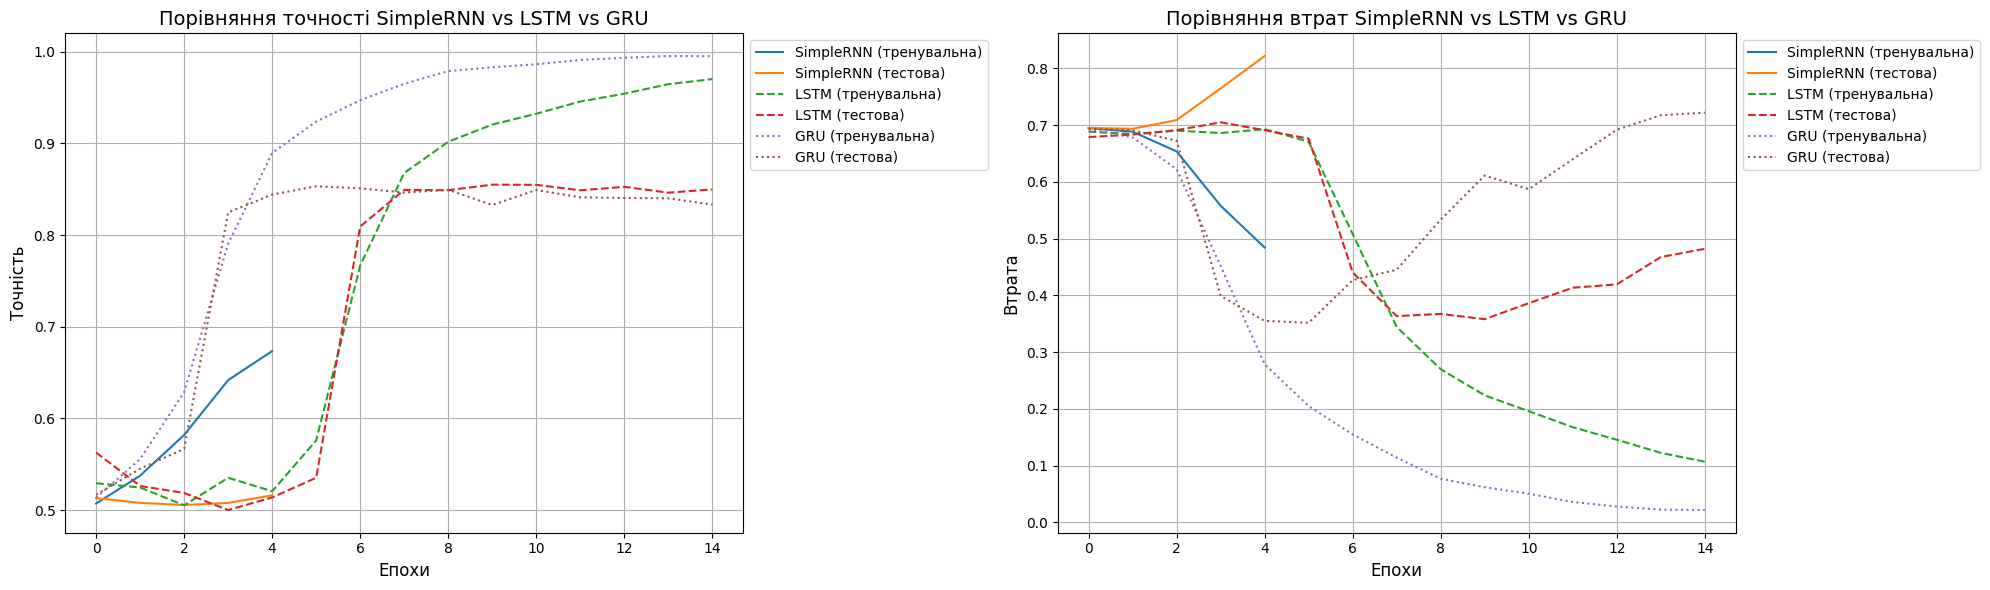

In [ ]:
# Створюємо фігуру з двома графіками
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Порівняння точності
axes[0].plot(history_simple_rnn.history['accuracy'], label='SimpleRNN (тренувальна)')
axes[0].plot(history_simple_rnn.history['val_accuracy'], label='SimpleRNN (тестова)')
axes[0].plot(history_lstm.history['accuracy'], label='LSTM (тренувальна)', linestyle="dashed")
axes[0].plot(history_lstm.history['val_accuracy'], label='LSTM (тестова)', linestyle="dashed")
axes[0].plot(history_gru.history['accuracy'], label='GRU (тренувальна)', linestyle="dotted")
axes[0].plot(history_gru.history['val_accuracy'], label='GRU (тестова)', linestyle="dotted")
axes[0].set_xlabel('Епохи', fontsize=12)
axes[0].set_ylabel('Точність', fontsize=12)
axes[0].set_title('Порівняння точності SimpleRNN vs LSTM vs GRU', fontsize=14)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
axes[0].grid(True)

# Порівняння втрат
axes[1].plot(history_simple_rnn.history['loss'], label='SimpleRNN (тренувальна)')
axes[1].plot(history_simple_rnn.history['val_loss'], label='SimpleRNN (тестова)')
axes[1].plot(history_lstm.history['loss'], label='LSTM (тренувальна)', linestyle="dashed")
axes[1].plot(history_lstm.history['val_loss'], label='LSTM (тестова)', linestyle="dashed")
axes[1].plot(history_gru.history['loss'], label='GRU (тренувальна)', linestyle="dotted")
axes[1].plot(history_gru.history['val_loss'], label='GRU (тестова)', linestyle="dotted")
axes[1].set_xlabel('Епохи', fontsize=12)
axes[1].set_ylabel('Втрата', fontsize=12)
axes[1].set_title('Порівняння втрат SimpleRNN vs LSTM vs GRU', fontsize=14)
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
axes[1].grid(True)

plt.tight_layout()
plt.show()

📊 **Порівняння з іншими моделями**:  
- **SimpleRNN** → швидко навчається, але не може добре обробляти довгі послідовності → **не підходить** для цієї задачі.  
- **LSTM** → **найкращий баланс між точністю та узагальненням**, дає **найстабільніші результати**.  
- **GRU** → навчається швидше за LSTM, але схильне до **перенавчання** та показує трохи **гіршу узагальнюючу здатність**.

---
💡 **Остаточний вибір** → **LSTM** ✅  
LSTM стабільно навчається, дає високу точність на тестових даних **(≈85%)** і не має сильного перенавчання.  

---
📌 **Можливі покращення**:  
🔹 Додати **Bidirectional LSTM** для покращення узагальнення.  
🔹 Спробувати **регуляризацію (Dropout 0.4-0.5)** для боротьби з перенавчанням.  
🔹 Використати **переднавчений word embedding** (`GloVe`, `Word2Vec`).  

---
# 🎯 **Фінальний висновок**: LSTM – **найкращий вибір для цього завдання!** ✅